In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 6E83-A13F

 Directory of C:\Users\Kamika Hughes

10/21/2022  10:02 PM    <DIR>          .
04/14/2022  12:12 AM    <DIR>          ..
04/25/2022  05:18 PM    <DIR>          .conda
10/21/2022  09:41 PM    <DIR>          .ipynb_checkpoints
10/20/2022  12:21 PM    <DIR>          .ipython
10/19/2022  09:45 PM    <DIR>          .jupyter
10/20/2022  06:40 PM    <DIR>          .keras
10/01/2022  10:00 PM    <DIR>          .matplotlib
09/20/2022  08:47 PM    <DIR>          .ms-ad
10/21/2022  09:57 PM    <DIR>          anaconda3
10/21/2022  10:02 PM            24,876 CDLA-Permissive-2.0.pdf
04/13/2022  11:50 PM    <DIR>          Contacts
10/02/2022  02:58 PM    <DIR>          Desktop
10/19/2022  08:02 PM    <DIR>          Documents
10/21/2022  08:39 PM    <DIR>          Downloads
04/13/2022  11:50 PM    <DIR>          Favorites
10/21/2022  08:28 PM         1,989,289 Kamika Hughes Final.ipynb
04/13/2022  11:50 PM    <DIR>          Links
10/21/

In [4]:
!dir kagglecatsanddogs_3367a

 Volume in drive C is Windows
 Volume Serial Number is 6E83-A13F

 Directory of C:\Users\Kamika Hughes\kagglecatsanddogs_3367a

10/21/2022  08:38 PM    <DIR>          .
10/21/2022  09:25 PM    <DIR>          ..
10/21/2022  08:38 PM            35,545 MSR-LA - 3467.docx
10/21/2022  08:40 PM    <DIR>          PetImages
10/21/2022  08:38 PM               104 readme[1].txt
               2 File(s)         35,649 bytes
               3 Dir(s)  359,685,177,344 bytes free


In [5]:
!dir kagglecatsanddogs_3367a\PetImages

 Volume in drive C is Windows
 Volume Serial Number is 6E83-A13F

 Directory of C:\Users\Kamika Hughes\kagglecatsanddogs_3367a\PetImages

10/21/2022  08:40 PM    <DIR>          .
10/21/2022  08:38 PM    <DIR>          ..
10/21/2022  08:51 PM    <DIR>          Cat
10/21/2022  08:52 PM    <DIR>          Dog
               0 File(s)              0 bytes
               4 Dir(s)  359,685,124,096 bytes free


In [6]:
data_file = 'kagglecatsanddogs_3367a\PetImages'
data_file

'kagglecatsanddogs_3367a\\PetImages'

In [7]:
import os
import matplotlib.pyplot as plt

In [8]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_file, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [9]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


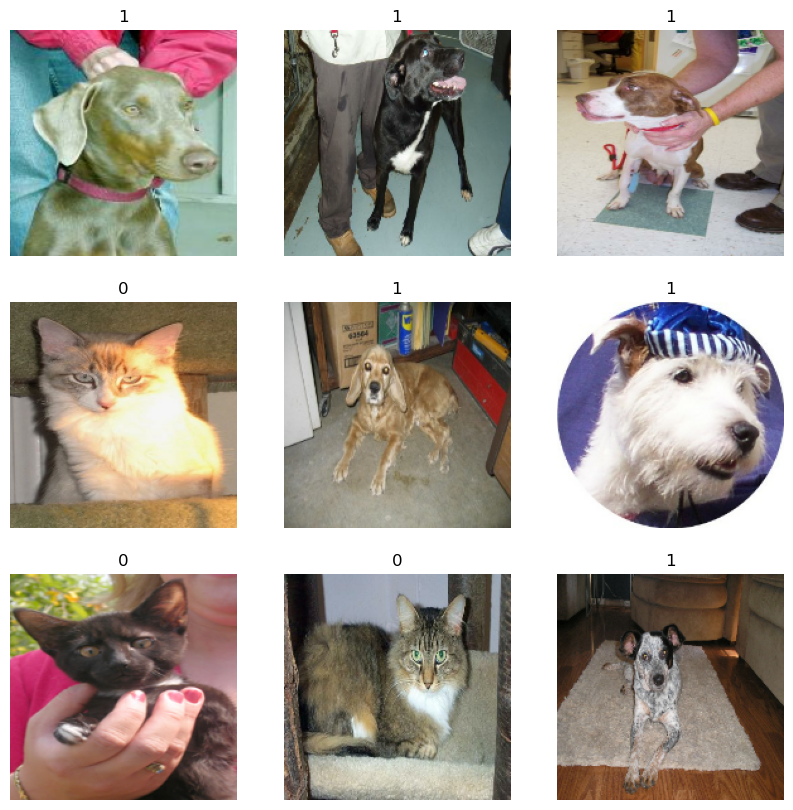

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

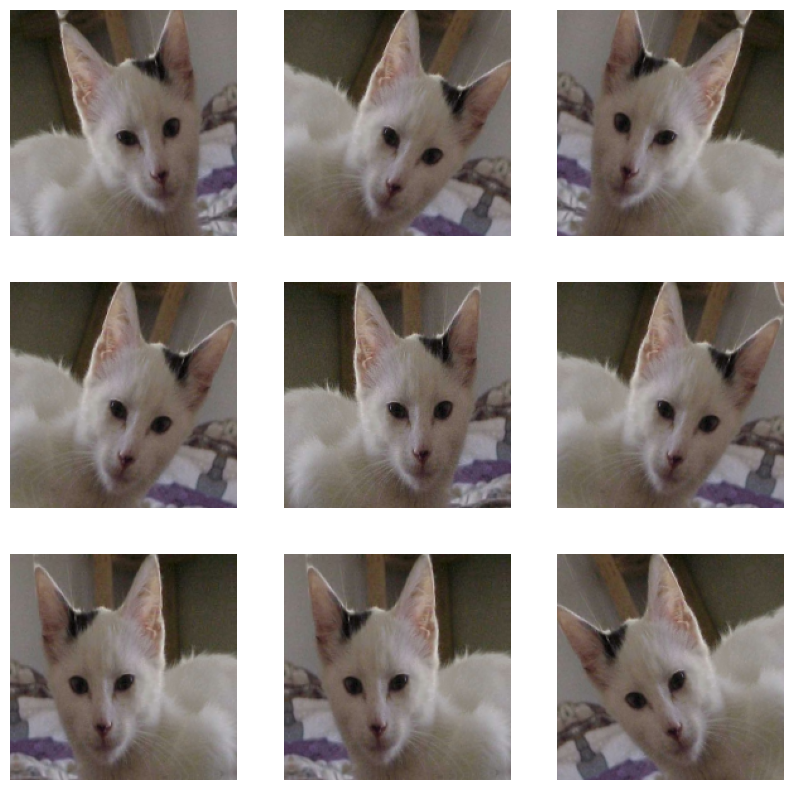

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)




In [16]:
import pydot

In [17]:
import graphviz

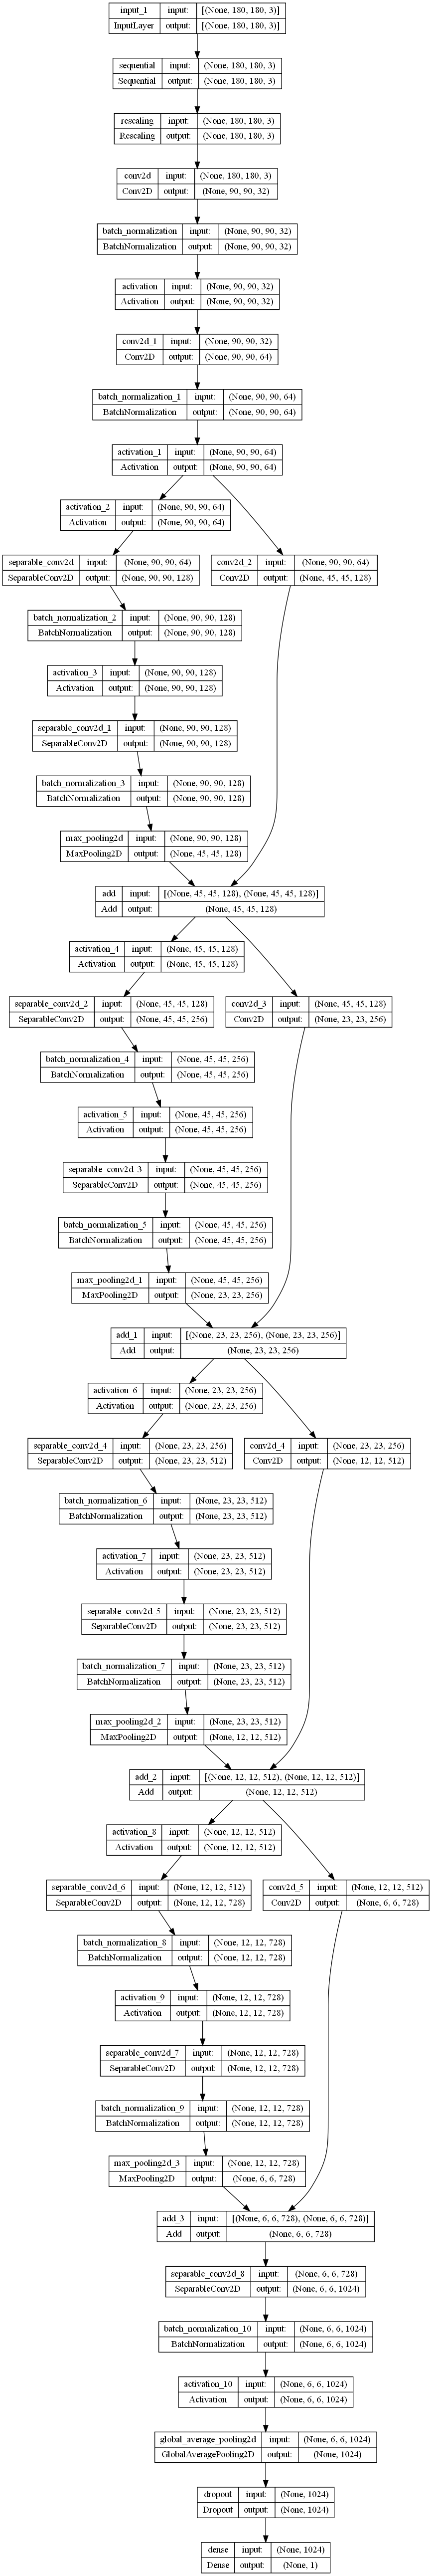

In [18]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

The Rescaling layer of the code helps to normalize data, it would be useful to when the data isn’t consistent. The Conv2D layer trains elements/layers of convolutional NN images, giving it weight so the data under that kernel can be multiplied element wise. Batch Normalization layers help make the network faster by adding another layer of rescaling and re-centering to the input. Activation matches what it gets, meaning it outputs small values if it gets a small input, and if it gets large inputs that exceed the threshold, it will output large values. SeperableConv2D works depth wise, it works on spatial convolutions and pointwise convolutions on each input separately helping to mix outputs. MaxPooling pulls the largest information and proceeds with that only. GlobalAveragePooling2D gets the mean of height and width of input values. 

In [20]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
  8/625 [..............................] - ETA: 22:13 - loss: 0.7479 - accuracy: 0.6172

InvalidArgumentError: Graph execution error:

Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_23003]

In [21]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 395ms/step
This image is 49.82 percent cat and 50.18 percent dog.
